<a href="https://colab.research.google.com/github/yeb2Binfang/DS_GY_3001_CV/blob/main/HW/HW2/homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2: Canny edge detector

**Due date:** October 15th 2019

The goal of the assignment is to implement a Canny edge detector. You should return the completed notebook, including answers and illustrations. 

If you are using [anaconda](https://www.anaconda.com/distribution/) you will have necessary libraries, if not, you may need to install them.

**Load and visualize image**

--2021-03-10 22:54:43--  https://raw.githubusercontent.com/yeb2Binfang/DS_GY_3001_CV/main/HW/HW2/lena.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105764 (103K) [image/jpeg]
Saving to: ‘lena.jpg’

lena.jpg            100%[===================>] 103.29K  --.-KB/s    in 0.02s   

2021-03-10 22:54:43 (4.07 MB/s) - ‘lena.jpg’ saved [105764/105764]



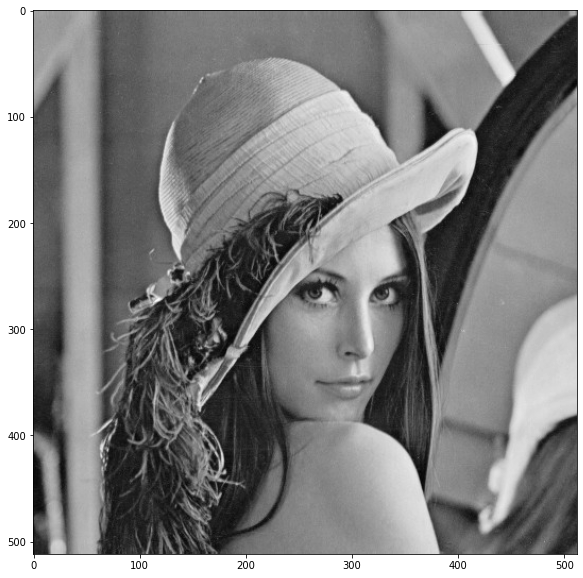

In [113]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import scipy.ndimage as ndimage #image processing library

# by default, the grayscale images are displayed with the jet colormap: use grayscale instead
plt.rcParams['image.cmap'] = 'gray'  

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray
# get image
!wget https://raw.githubusercontent.com/yeb2Binfang/DS_GY_3001_CV/main/HW/HW2/lena.jpg -O lena.jpg
name = './lena.jpg'
img = plt.imread(name)
img = rgb2gray(img)
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(img)

**Detailed instructions:**

https://www.cnblogs.com/king-lps/p/8007134.html

a- Compute a binary image corresponding to thresholding the norm of the gradient. You may use the function `ndimage.gaussian_filter` to compute the derivative of gaussian filter (see [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)). Discuss the parameters (there are two) and their influence on the results.

steps:
Explain the reason why we need to remove the noise

In [114]:
import cv2
img_remove = cv2.GaussianBlur(img,(5,5),0) # Apply Gaussian filter to remove noise

compare the spectrogram

In [115]:
def get_spectrogram(img):
  ## must be grey image
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  fimg = np.log(np.abs(fshift))
  plt.imshow(fimg, 'gray')

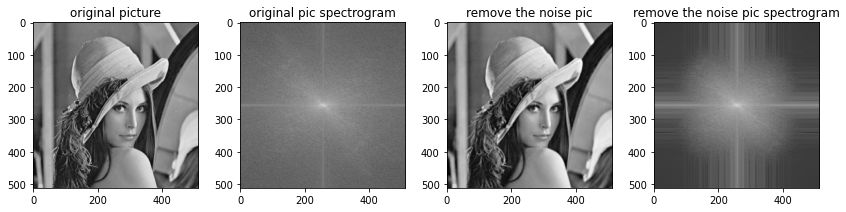

In [116]:
plt.figure(figsize=(12,8))

plt.subplot(141)
plt.imshow(img)
plt.title('original picture')

plt.subplot(142)
get_spectrogram(img)
plt.title('original pic spectrogram')

plt.subplot(143)
plt.imshow(img_remove)
plt.title('remove the noise pic')

plt.subplot(144)
get_spectrogram(img_remove)
plt.title('remove the noise pic spectrogram')

plt.tight_layout()

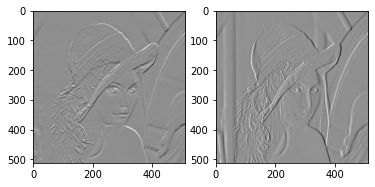

In [117]:
from scipy.ndimage import gaussian_filter
plt.subplot(121)
Gy=ndimage.gaussian_filter(img, 1, (1,0))
plt.imshow(Gy)

plt.subplot(122)
Gx=ndimage.gaussian_filter(img, 1, (0,1))
plt.imshow(Gx)



In [118]:
threshold = 1
G = np.sqrt(Gx**2+Gy**2)
G *= 255.0 / G.max()

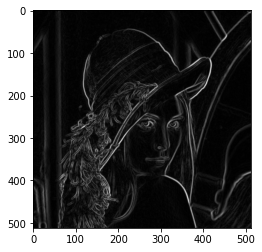

In [119]:
plt.imshow(G)

In [123]:
print(G)

[[ 1.55818565  1.60591164  1.43078473 ... 36.87782948 58.41738664
  29.64217222]
 [ 1.65103972  0.85448183  2.19126791 ... 35.35553582 59.48307818
  30.97360149]
 [ 1.83933306  0.79726862  3.18021451 ... 33.92817963 58.32184348
  31.19134011]
 ...
 [ 6.9810096   7.89671468  7.65983825 ...  8.43723875 12.22171997
  14.85091928]
 [ 3.53481091 12.05521569 11.48350958 ...  6.793818   10.08169853
  12.9573201 ]
 [ 4.19456038 14.56130484 11.50685983 ...  8.53981133  7.81170326
   5.71366529]]


In [172]:
## calculate the theta
import math
g_theta = np.arctan2(Gy,Gx)
gx,gy = g_theta.shape
theta = np.zeros((gx,gy))
for i in range(gx):
  for j in range(gy):
    theta[i][j] = np.rad2deg(g_theta[i][j])
theta = np.abs(theta)
print(np.min(theta))

0.0002259910978092316


In [127]:
print(np.max(G))

255.0


In [ ]:
m,n = G.shape
nms_img = np.zeros((m,n))
print(nms_img[0][0])

0.0


In [128]:
def threshold_norm(G,threshold):
  m,n = G.shape
  threshold_norm_G = np.zeros((m,n))
  for i in range(1,m-1):
    for j in range(1,n-1):
      if G[i][j]>threshold:
        threshold_norm_G[i][j] = G[i][j]
  return threshold_norm_G

In [129]:
threshold_norm_G = threshold_norm(G,5)

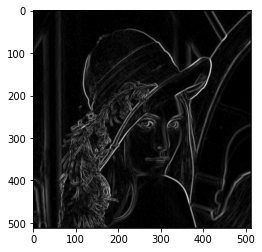

In [130]:
plt.imshow(threshold_norm_G)

In [131]:
print(threshold_norm_G)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ... 35.35553582 59.48307818
   0.        ]
 [ 0.          0.          0.         ... 33.92817963 58.32184348
   0.        ]
 ...
 [ 0.          7.89671468  7.65983825 ...  8.43723875 12.22171997
   0.        ]
 [ 0.         12.05521569 11.48350958 ...  6.793818   10.08169853
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [162]:
print(theta)

[[  12.02941639    3.12534131 -170.05674996 ...  178.07496694
   179.02107902 -179.09215093]
 [  43.47558261   10.54223029 -154.14745121 ...  179.99962127
   178.8991066   179.41261344]
 [  77.32457287  161.73261636 -156.42283174 ... -173.43480621
  -177.66771564 -177.32106133]
 ...
 [ -80.99291664  -23.85945937   15.17550933 ...   81.0104236
    96.51880137   90.41064857]
 [ -31.48120692    5.54793117   22.48926446 ...   42.20043212
    71.74309893   83.29031276]
 [   0.4198011     4.13348882    9.16587095 ...    6.8277527
    26.40996959   60.98507129]]


b- Write a function `nms(g_norm,g_theta)` which takes as input the gradient norm and direction and outputs a binary image with value 1 only for pixels that correspond to a maximum in the direction of the gradient.

In [160]:
def nms(g_norm, g_theta):
  img_row, img_col = g_norm.shape
  nms_img = np.zeros((img_row, img_col))
  p=q=255
  for row in range(1, img_row - 1):
    for col in range(1, img_col - 1):
      degree = g_theta[row][col]

      # map to 0
      if (0<=degree<22.5) or (157.5<=degree<=180):
        p = g_norm[row][col-1]
        r = g_norm[row][col+1]
      # map to 45
      elif (22.5<=degree<67.5):
        p = g_norm[row-1][col+1]
        r = g_norm[row+1][col-1]
      # map to 90
      elif (67.5<=degree<112.5):
        p = g_norm[row+1][col]
        r = g_norm[row-1][col]
      # map to 135
      else:
        p = g_norm[row-1][col-1]
        r = g_norm[row+1][col+1]
      
      if (g_norm[row][col] > p and g_norm[row][col] > r):
        nms_img[row][col] = g_norm[row][col]
  return nms_img


In [173]:
nms_img = nms(G,theta)

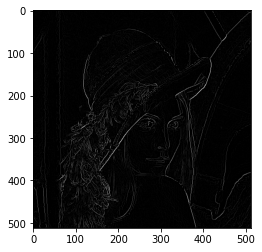

In [174]:
plt.imshow(nms_img)

In [165]:
def non_max_suppression(gradient_magnitude, gradient_direction, verbose):
    image_row, image_col = gradient_magnitude.shape

    output = np.zeros(gradient_magnitude.shape)

    PI = 180

    for row in range(1, image_row - 1):
        for col in range(1, image_col - 1):
            direction = gradient_direction[row, col]

            # (0 - PI/8 and 15PI/8 - 2PI)
            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]

            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]

            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col]

            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]

            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output[row, col] = gradient_magnitude[row, col]

    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Non Max Suppression")
        plt.show()

    return output

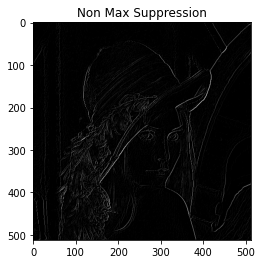

In [175]:
ou = non_max_suppression(threshold_norm_G,g_theta,verbose=True)

In [99]:
print(ou)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.         59.48307818
   0.        ]
 [ 0.          0.          0.         ...  0.         58.32184348
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         12.22171997
   0.        ]
 [ 0.         12.05521569  0.         ...  0.         10.08169853
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [79]:
res = nms(threshold_norm_G,theta)

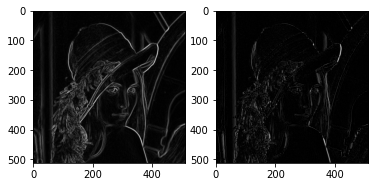

In [80]:
plt.subplot(121)
plt.imshow(G)
plt.subplot(122)
plt.imshow(res, cmap = plt.get_cmap('gray'))

In [67]:
print(res)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.57130789 ...  9.21790372 15.50844232
   0.        ]
 [ 0.          0.20786406  0.82914628 ...  8.84576308 15.20568493
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          3.14303871  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


c- Combine step 'a' and 'b' to extract edges with a gradient norm larger than a given threshold.

d- Add the hysteresis thresholding to step 'c' to implement a function computing the Canny edges.

Here is one way to do the hysteresis thresholding. Apply step 'c' with two thresholds $t_1 < t_2$. This yields a set of "strong pixels" (large threshold) and "weak pixels" (small threshold). Initialize a list of edge pixels by including only the set of strong pixels. For each pixel in this list, check if its neighboors are weak pixels. If they are, add them to the list of pixels to visit.

In [71]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
  highThreshold = img.max() * highThresholdRatio;
  lowThreshold = highThreshold * lowThresholdRatio;
  
  M, N = img.shape
  res = np.zeros((M,N), dtype=np.int32)
  
  weak = np.int32(25)
  strong = np.int32(255)
  
  strong_i, strong_j = np.where(img >= highThreshold)
  zeros_i, zeros_j = np.where(img < lowThreshold)
  
  weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
  
  res[strong_i, strong_j] = strong
  res[weak_i, weak_j] = weak
  
  return res, weak

In [72]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [73]:
print(res)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.57130789 ...  9.21790372 15.50844232
   0.        ]
 [ 0.          0.20786406  0.82914628 ...  8.84576308 15.20568493
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          3.14303871  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [74]:
fin, weak = threshold(res)

In [75]:
fin1 = hysteresis(fin,weak)

e- Run your code on at least four images of your own choosing. Use different parameters and comment on their effects.

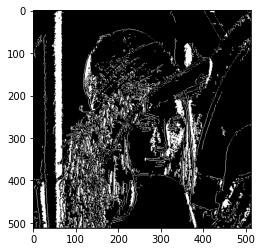

In [76]:
plt.imshow(fin1)

In [91]:
def threshold(image, low, high, weak, verbose=False):
    output = np.zeros(image.shape)

    strong = 255

    strong_row, strong_col = np.where(image >= high)
    weak_row, weak_col = np.where((image <= high) & (image >= low))

    output[strong_row, strong_col] = strong
    output[weak_row, weak_col] = weak

    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("threshold")
        plt.show()

    return output

In [92]:
def hysteresis(image, weak):
    image_row, image_col = image.shape

    top_to_bottom = image.copy()

    for row in range(1, image_row):
        for col in range(1, image_col):
            if top_to_bottom[row, col] == weak:
                if top_to_bottom[row, col + 1] == 255 or top_to_bottom[row, col - 1] == 255 or top_to_bottom[row - 1, col] == 255 or top_to_bottom[
                    row + 1, col] == 255 or top_to_bottom[
                    row - 1, col - 1] == 255 or top_to_bottom[row + 1, col - 1] == 255 or top_to_bottom[row - 1, col + 1] == 255 or top_to_bottom[
                    row + 1, col + 1] == 255:
                    top_to_bottom[row, col] = 255
                else:
                    top_to_bottom[row, col] = 0

    bottom_to_top = image.copy()

    for row in range(image_row - 1, 0, -1):
        for col in range(image_col - 1, 0, -1):
            if bottom_to_top[row, col] == weak:
                if bottom_to_top[row, col + 1] == 255 or bottom_to_top[row, col - 1] == 255 or bottom_to_top[row - 1, col] == 255 or bottom_to_top[
                    row + 1, col] == 255 or bottom_to_top[
                    row - 1, col - 1] == 255 or bottom_to_top[row + 1, col - 1] == 255 or bottom_to_top[row - 1, col + 1] == 255 or bottom_to_top[
                    row + 1, col + 1] == 255:
                    bottom_to_top[row, col] = 255
                else:
                    bottom_to_top[row, col] = 0

    right_to_left = image.copy()

    for row in range(1, image_row):
        for col in range(image_col - 1, 0, -1):
            if right_to_left[row, col] == weak:
                if right_to_left[row, col + 1] == 255 or right_to_left[row, col - 1] == 255 or right_to_left[row - 1, col] == 255 or right_to_left[
                    row + 1, col] == 255 or right_to_left[
                    row - 1, col - 1] == 255 or right_to_left[row + 1, col - 1] == 255 or right_to_left[row - 1, col + 1] == 255 or right_to_left[
                    row + 1, col + 1] == 255:
                    right_to_left[row, col] = 255
                else:
                    right_to_left[row, col] = 0

    left_to_right = image.copy()

    for row in range(image_row - 1, 0, -1):
        for col in range(1, image_col):
            if left_to_right[row, col] == weak:
                if left_to_right[row, col + 1] == 255 or left_to_right[row, col - 1] == 255 or left_to_right[row - 1, col] == 255 or left_to_right[
                    row + 1, col] == 255 or left_to_right[
                    row - 1, col - 1] == 255 or left_to_right[row + 1, col - 1] == 255 or left_to_right[row - 1, col + 1] == 255 or left_to_right[
                    row + 1, col + 1] == 255:
                    left_to_right[row, col] = 255
                else:
                    left_to_right[row, col] = 0

    final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right

    final_image[final_image > 255] = 255

    return final_image

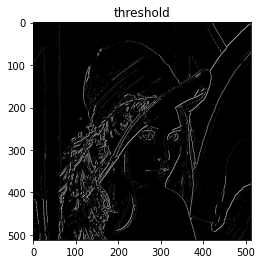

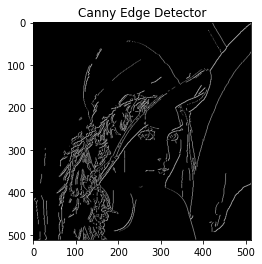

In [112]:
weak = 50

new_image = threshold(ou, 25, 60, weak=weak, verbose=True)

new_image = hysteresis(new_image, weak)

plt.imshow(new_image, cmap='gray')
plt.title("Canny Edge Detector")
plt.show()

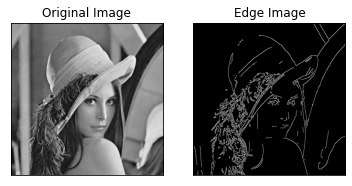

In [107]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('lena.jpg',0)
edges = cv2.Canny(img1,150,230)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()